In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-seg/Human-Segmentation-Dataset-master/README.md
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/173.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/248.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/94.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/236.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/48.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/227.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/238.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/61.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/222.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/278.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/37.png
/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Tr

Dataset Link:https://github.com/VikramShenoy97/Human-Segmentation-Dataset
      https://www.kaggle.com/datasets/nourabentaher/human-seg

In [3]:
import os
import time
import torch

from PIL import Image

from torch import nn
from torchvision import transforms

from torch.utils.data import DataLoader,Dataset
from torch.optim import Adam,AdamW,SGD


In [4]:
class SegmentationDataset(Dataset):
    def __init__(self,image_dir,mask_dir):
        self.image_dir=image_dir
        self.mask_dir=mask_dir
        self.transforms=transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
        ])

        valid_extension={".jpg",".jpeg",".png"}
        self.images=[file for file in os.listdir(image_dir) if os.path.splitext(file)[1].lower() in valid_extension]


    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_path=os.path.join(self.image_dir,self.images[idx])
        name,ext=os.path.splitext(self.images[idx])
        mask_path=os.path.join(self.mask_dir,f'{name}.png')


        image=Image.open(img_path).convert('RGB')
        mask=Image.open(mask_path).convert('L')

        image=self.transforms(image)
        mask=self.transforms(mask)

        mask=(mask>0.5).float()

        return image,mask
    
        

In [5]:
def get_dataloader(img_dir,mask_dir,batch_size=2,shuffle=True):
    dataset=SegmentationDataset(img_dir,mask_dir)
    return DataLoader(dataset,batch_size=batch_size,shuffle=shuffle)

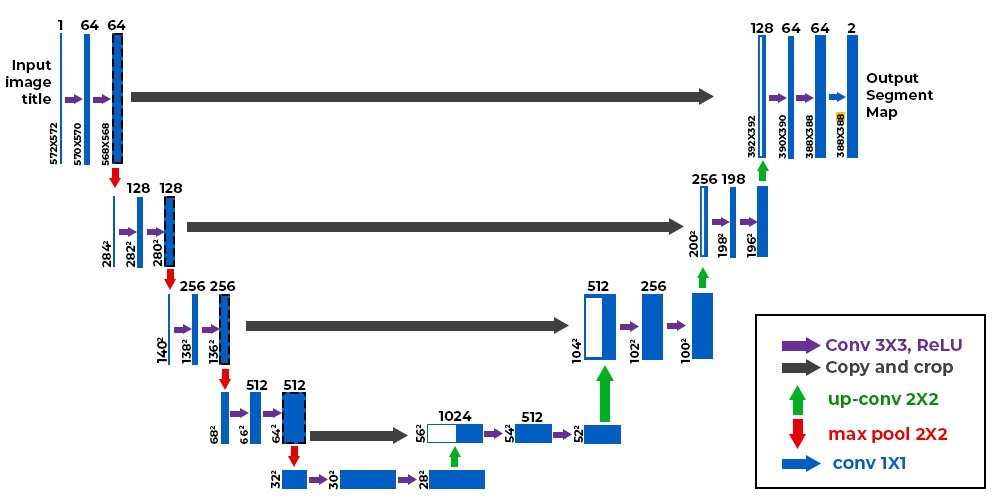
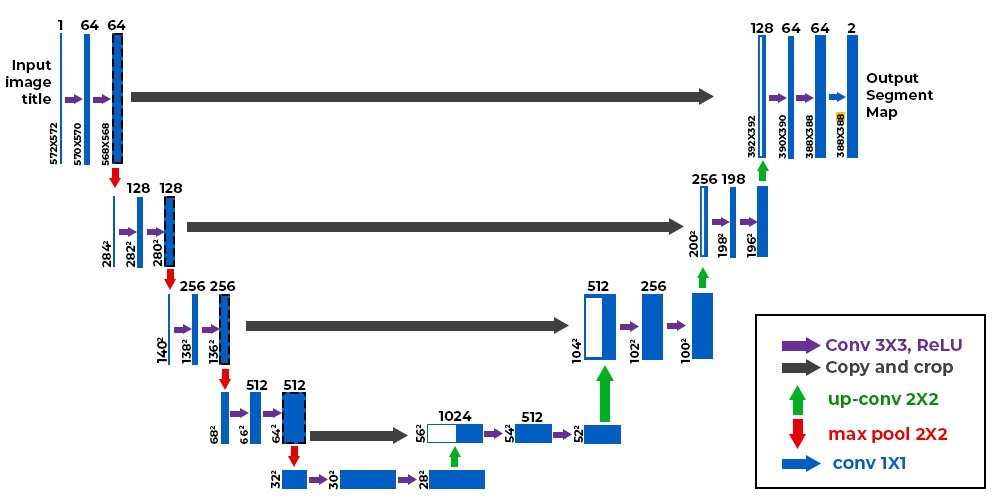

In [6]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv_op=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self,x):
        return self.conv_op(x)

In [7]:
class DownSample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv=DoubleConv(in_channels,out_channels)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self,x):
        down=self.conv(x)
        p=self.pool(down)
        return down,p

In [8]:
class UpSample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.up=nn.ConvTranspose2d(in_channels,in_channels//2,kernel_size=2,stride=2)
        self.conv=DoubleConv(in_channels,out_channels)

    def forward(self,x1,x2):
        x1=self.up(x1)
        x=torch.cat([x1,x2],1)
        return self.conv(x)

In [9]:
class UNet(nn.Module):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        self.down_conv_1=DownSample(in_channels,64)
        self.down_conv_2=DownSample(64,128)
        self.down_conv_3=DownSample(128,256)
        self.down_conv_4=DownSample(256,512)

        self.bottle_neck=DoubleConv(512,1024)

        self.up_conv_1=UpSample(1024,512)
        self.up_conv_2=UpSample(512,256)
        self.up_conv_3=UpSample(256,128)
        self.up_conv_4=UpSample(128,64)

        self.out=nn.Conv2d(in_channels=64,out_channels=num_classes,kernel_size=1)

    def forward(self,x):
        down_1,p1=self.down_conv_1(x)
        down_2,p2=self.down_conv_2(p1)
        down_3,p3=self.down_conv_3(p2)
        down_4,p4=self.down_conv_4(p3)

        b=self.bottle_neck(p4)

        up_1=self.up_conv_1(b,down_4)
        up_2=self.up_conv_2(up_1,down_3)
        up_3=self.up_conv_3(up_2,down_2)
        up_4=self.up_conv_4(up_3,down_1)

        out=self.out(up_4)
        return out

In [10]:
class DiceLoss(nn.Module):
    def __init__(self,smooth=1e-6):
        super(DiceLoss,self).__init__()
        self.smooth=smooth

    def forward(self,inputs,targets):
        inputs=inputs.view(-1)
        targets=targets.view(-1)

        intersection=(inputs*targets).sum()
        dice_score=(2.*intersection+self.smooth)/(inputs.sum()+targets.sum()+self.smooth)

        return 1-dice_score

In [11]:
class BCEWithDiceLoss(nn.Module):
    def __init__(self,smooth=1e-6):
        super(BCEWithDiceLoss,self).__init__()
        self.bce=nn.BCEWithLogitsLoss()
        self.dice=DiceLoss()

    def forward(self,inputs,targets):
        bce_loss=self.bce(inputs,targets)
        dice_loss=self.dice(inputs,targets)
        return 0.5*bce_loss+dice_loss
        

##### Train Loop

In [12]:
def train(model,dataloader,epochs=5,lr=0.001,save_path='/kaggle/working/unet_model',load_path=None):
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if load_path and os.path.exists(load_path):
        print(f'Loading Model Weights from {load_path}')
        model.load_state_dict(torch.load(load_path,map_location=device))
    else:
        print(f'No Checkpoint found,training from scratch')
    print(device)
    model.to(device)

    criterion=BCEWithDiceLoss()

    optimizer=SGD(model.parameters(),lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_loss=0

        for images,masks in dataloader:
            images,masks = images.to(device),masks.to(device)
            optimizer.zero_grad()

            output=model(images)
            loss=criterion(output,masks)
            loss.backward()
            optimizer.step()

            epoch_loss+=loss.item()
        avg_loss=epoch_loss/len(dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, LR:{lr}')

        if epoch%10==0 and epoch>0:
            torch.save(model.state_dict(),f'/kaggle/working/unet_epoch{epoch+1}.pth')

    torch.save(model.state_dict(),f'{save_path}_final.pth')
    print(f'Model Saved to {save_path}')
    

In [13]:
dataloader=get_dataloader('/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Training_Images/','/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Ground_Truth/',batch_size=2,shuffle=True)

In [14]:
model=UNet(in_channels=3,num_classes=1)

In [16]:
train(model,dataloader,epochs=10,lr=1e-4,load_path='/kaggle/working/unet_epoch41.pth')

Loading Model Weights from /kaggle/working/unet_epoch41.pth
cuda
Epoch [1/10], Loss: 1.0807, LR:0.0001
Epoch [2/10], Loss: 1.0818, LR:0.0001
Epoch [3/10], Loss: 1.0822, LR:0.0001
Epoch [4/10], Loss: 1.0807, LR:0.0001
Epoch [5/10], Loss: 1.0804, LR:0.0001
Epoch [6/10], Loss: 1.0792, LR:0.0001
Epoch [7/10], Loss: 1.0779, LR:0.0001
Epoch [8/10], Loss: 1.0801, LR:0.0001
Epoch [9/10], Loss: 1.0785, LR:0.0001
Epoch [10/10], Loss: 1.0784, LR:0.0001
Model Saved to /kaggle/working/unet_model


##### Inference on Trained Model

In [30]:
import numpy as np

def predict(model_path,input_image):
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # load model
    model=UNet(in_channels=3,num_classes=1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # track start timt
    total_start_time=time.time()

    # image preprocessing
    preprocess_start_time=time.time()
    image=Image.open(input_image).convert('RGB')
    transform=transforms.Compose([
                                transforms.Resize((512,512)),
                                transforms.ToTensor(),
                                ])
    image_tensor=transform(image).unsqueeze(0).to(device)
    preprocess_end_time=time.time()

    # model inference
    inference_start_time=time.time()
    with torch.no_grad():
        output=model(image_tensor)
        output=torch.sigmoid(output)
    inference_end_time=time.time()

    # postprocessing
    postprocess_start_time=time.time()
    mask=output.squeeze(0).squeeze(0).cpu().numpy()
    mask=(mask>0.4).astype(np.uint8)*255
    mask_image=Image.fromarray(mask)

    combined=Image.new('RGB',(512*2,512))
    combined.paste(image.resize((512,512)),(0,0))
    combined.paste(mask_image.convert('RGB'),(512,0))
    combined.save('/kaggle/working/output.jpg')
    postprocess_end_time=time.time()

    # calculate timing stats
    total_end_time=time.time()

    preprocess_time=preprocess_end_time-preprocess_start_time
    inference_time=inference_end_time-inference_start_time
    postprocess_time=postprocess_end_time-postprocess_start_time
    total_time=total_end_time-total_start_time

    # print stats
    print(f'Prediction Completed! Stats:')
    print(f'Image PreProcessing Time: {preprocess_time:.4f} seconds')
    print(f'Model Inference Time: {inference_time:.4f} seconds')
    print(f'PostProcessing Time: {postprocess_time:.4f} seconds')
    print(f'Total Prediction Time: {total_time:.4f} seconds')
    print(f'Prediction saved as output.jpg')
    

In [31]:
predict(model_path='/kaggle/working/unet_epoch41.pth',input_image='/kaggle/input/human-seg/Human-Segmentation-Dataset-master/Training_Images/5.jpg')

Using device: cuda
Prediction Completed! Stats:
Image PreProcessing Time: 0.0068 seconds
Model Inference Time: 0.0022 seconds
PostProcessing Time: 0.1194 seconds
Total Prediction Time: 0.1284 seconds
Prediction saved as output.jpg
